In [61]:
from exif import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import cv2
import imutils

This code names the photos in a folder according to their time taken and puts them in a sorted array

In [62]:
path="blackCardTest/" #Folder where images are
photos = [] #Array for filepaths
for filename in os.listdir(path):
    my_source = path + filename
    if Image(my_source).has_exif: #Checks for exif data
        my_dest = Image(my_source).datetime_original + ".jpg" #The time taken + .jpg
      
    my_dest = path + my_dest
    os.rename(my_source, my_dest) #Renames the images
    photos.append(my_dest) #Adds the filepath of the image to an array
    
photos.sort() #Sorts the array by time taken
print(photos)

['blackCardTest/2023:03:20 11:57:54.jpg', 'blackCardTest/2023:03:20 11:57:59.jpg', 'blackCardTest/2023:03:20 11:58:05.jpg', 'blackCardTest/2023:03:20 11:58:09.jpg', 'blackCardTest/2023:03:20 11:58:13.jpg', 'blackCardTest/2023:03:20 11:58:18.jpg', 'blackCardTest/2023:03:20 11:58:22.jpg', 'blackCardTest/2023:03:20 11:58:27.jpg', 'blackCardTest/2023:03:20 11:58:31.jpg', 'blackCardTest/2023:03:20 11:58:35.jpg', 'blackCardTest/2023:03:20 11:58:40.jpg', 'blackCardTest/2023:03:20 11:58:44.jpg', 'blackCardTest/2023:03:20 11:58:51.jpg', 'blackCardTest/2023:03:20 11:58:56.jpg', 'blackCardTest/2023:03:20 11:59:01.jpg', 'blackCardTest/2023:03:20 11:59:06.jpg', 'blackCardTest/2023:03:20 11:59:11.jpg', 'blackCardTest/2023:03:20 11:59:17.jpg', 'blackCardTest/2023:03:20 11:59:24.jpg', 'blackCardTest/2023:03:20 11:59:29.jpg', 'blackCardTest/2023:03:20 11:59:35.jpg']


This code finds the separation between points for each photo and draws a line for visualisation

In [63]:
seps = []
freq = []
i = 140

#Finds the separation values of each pattern, as well as draws a line to visualise each plot
for filename in photos:
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (89, 89), 0)
    thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
    
    # find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    #Centre of second maxima
    M = cv2.moments(cnts[1])
    if M["m00"] != 0:
        startX = int(M["m10"] / M["m00"])
        startY = int(M["m01"] / M["m00"])
    else:
        startX = 0
        startY = 0
    
    #Centre of third maxima
    N = cv2.moments(cnts[2])
    if N["m00"] != 0:
        endX = int(N["m10"] / N["m00"])
        endY = int(N["m01"] / N["m00"])
    else:
        endX = 0
        endY = 0
    
    #Separation using pythag 
    separation = np.sqrt((endY - startY)**2 + (endX - startX)**2)/14526
    cv2.line(image, (startX, startY), (endX, endY), (0, 255, 0), thickness=2) #Paint line on image
    cv2.imwrite("blackCardTestLines/" + str(i) + "_Line.jpeg", image) #Save image with the line
    seps.append(separation) #Put separation value into array
    freq.append(i) #Put frequency value into array
    
    i += 10

print(seps)

[0.012538521660306185, 0.011779239348698222, 0.012263361370959373, 0.011779239348698222, 0.012194572765958716, 0.012607313151941028, 0.011641640873903961, 0.012125784767870396, 0.01240094036129875, 0.01281646451312156, 0.01322914734899002, 0.013504281795664853, 0.013985789226984272, 0.014398530497446795, 0.017630158697703457, 0.015020356651730063, 0.01563685291329756, 0.017086708730458918, 0.017499433716995756, 0.017912173800437404, 0.01770325893318093]


In [64]:
length = 2.583
deltaL = 0.001
deltaD = 2/15725
hVal = 0.15
deltaH = 0.005099
laserLambda = 0.000000633
kval = (np.pi * hVal * pd.Series(seps))/(laserLambda * (hVal**2 + length**2))
omega = 2 * np.pi * pd.Series(freq)

deltaKfromL = (pd.Series(seps) * hVal * 2 * length) * (1/((hVal**2 + length**2)**2)) * deltaL #DeltaK from length
deltaKfromD = hVal * (1/(hVal**2 + length**2)) * deltaD #DeltaK from separations
deltaKfromH = (pd.Series(seps)) * (length**2 - hVal**2) *(1/((hVal**2 + length**2)**2)) * deltaH #DeltaK from height calc

deltaK = (np.pi/laserLambda) * (deltaKfromL + deltaKfromD + deltaKfromH) #Uncertainty in k
deltaKCube = 3*(kval ** 2) * deltaK #Uncertainty in k cube
omegasq = omega ** 2
kcube = kval ** 3

print(kcube)
print(omegasq)

0     2.710931e+09
1     2.247663e+09
2     2.536343e+09
3     2.247663e+09
4     2.493901e+09
5     2.755796e+09
6     2.169812e+09
7     2.451935e+09
8     2.622668e+09
9     2.895237e+09
10    3.184014e+09
11    3.386834e+09
12    3.762187e+09
13    4.105196e+09
14    7.536125e+09
15    4.660368e+09
16    5.258084e+09
17    6.860483e+09
18    7.369727e+09
19    7.903588e+09
20    7.630256e+09
dtype: float64
0     7.737770e+05
1     8.882644e+05
2     1.010647e+06
3     1.140926e+06
4     1.279101e+06
5     1.425171e+06
6     1.579137e+06
7     1.740998e+06
8     1.910755e+06
9     2.088408e+06
10    2.273957e+06
11    2.467401e+06
12    2.668741e+06
13    2.877977e+06
14    3.095108e+06
15    3.320135e+06
16    3.553058e+06
17    3.793876e+06
18    4.042590e+06
19    4.299200e+06
20    4.563705e+06
dtype: float64


0.0005210711232612835


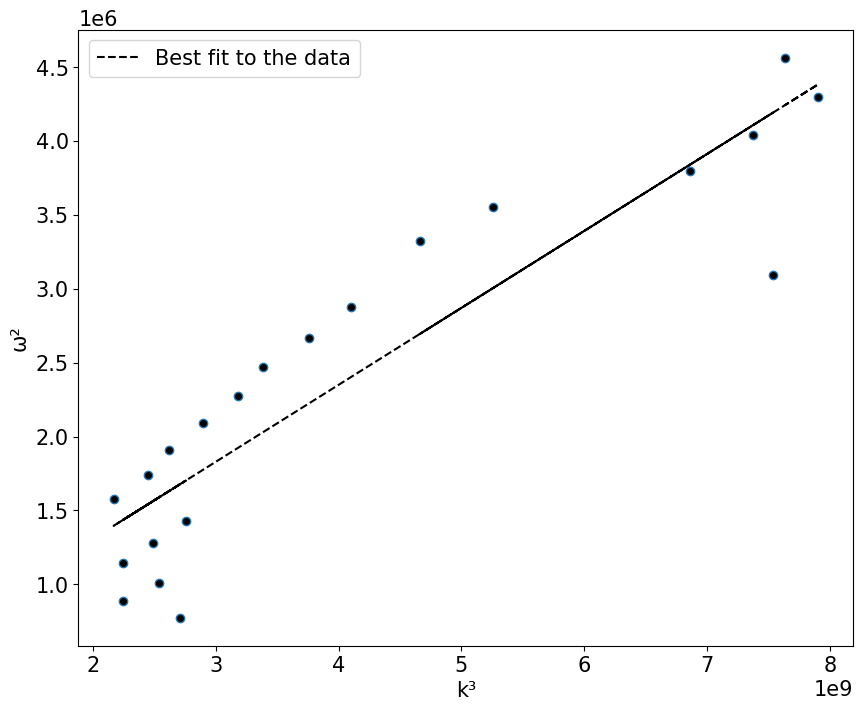

In [66]:
plt.rcParams['font.size'] = 15
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('k³')
ax.set_ylabel('ω²')

def line(x, slope, intercept):          # Set up the linear fitting - don't ammend
    return slope*x + intercept          # More set up, leave alone.

# Next few line, fits a line to the (x data, and y data) no need to change things.
popt, pcov = curve_fit(line,kcube,omegasq)
slope = popt[0]
intercept = popt[1]
err_slope = np.sqrt(float(pcov[0][0]))
err_intercept = np.sqrt(float(pcov[1][1]))

print(slope)

ax.scatter(kcube, omegasq)
ax.errorbar(kcube,           
             omegasq,                   
             marker='o',             
             markersize = 4,
             markerfacecolor = 'black',
             color='black',          
             linestyle='none',       
             capsize=6,              
           )

ax.plot(kcube, kcube*slope+intercept, 
         linestyle='--',
         color='black',
         label='Best fit to the data')

ax.legend(loc="upper left")



In [59]:
def line(x, slope, intercept):          # Set up the linear fitting - don't ammend
    return slope*x + intercept          # More set up, leave alone.

# Next few line, fits a line to the (x data, and y data) no need to change things.
popt, pcov = curve_fit(line,kcube,omegasq)
slope = popt[0]
intercept = popt[1]
err_slope = np.sqrt(float(pcov[0][0]))
err_intercept = np.sqrt(float(pcov[1][1]))

5.204257008053521e-07
